# Binary Classification of 747 vs A380
The goal is to classify a picture between two classes : an Boeing 747 or an Airbus A380.
*Spoiler :* This source code is 3 times better than Google AutoML on the same dataset !

Note : this Notebook was writen with old version  of fastai librairy and updated fot the new version.
For now, the old version (https://github.com/trancept/deep_learning_tests/blob/master/012-Binary_Classification_747_vs_A380-essential.ipynb) perform much better (98% accuracy vs 95%), I've to figure out why.

You may notice a strange line :

 !rm -r {PATH}tmp

It's there to remove temporary files to avoid messing out between different training.

## Dataset
It's an homemade dataset from Google Image.
There is a nice script to get images from Google : https://github.com/boxabirds/fastai-helpers/blob/master/training-data-generator.py, it's based on https://github.com/hardikvasa/google-images-download wich use ChromeDriver to automate the process.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
PATH = "../../datasets/boeing_vs_airbus/"
!rm -r {PATH}tmp
## Getting dataset
#!mkdir {PATH}
#!pip install google_images_download
#!ls ../../datasets/
#!cd {PATH} && mkdir -p train/747 train/A380 test/747 test/A380  valid/747 valid/A380
#!cd {PATH}/747 && googleimagesdownload --keywords "Boing 747" --limit 1000 --chromedriver /usr/local/bin/chromedriver
#!cd {PATH}/A380 && googleimagesdownload --keywords "Airbus A380" --limit 1000 --chromedriver /usr/local/bin/chromedriver
## Getting models weights
#!cd ./fastai && wget http://files.fast.ai/models/weights.tgz && tar -xvzf weights.tgz
#!ls {PATH}

rm: cannot remove '../../datasets/boeing_vs_airbus/tmp': No such file or directory


In [3]:
print("Setting CUDA devices...")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="6"

print("Loading Fast.AI modules...")
from fastai import *
from fastai.vision import *

sz=224
arch=models.resnet50
bs=132

Setting CUDA devices...
Loading Fast.AI modules...


In [4]:
print("CuDNN optimization is ", torch.backends.cudnn.enabled)

CuDNN optimization is  True


# Training from sratch
We begin with an empty Resnet50 model.

### Prepare data and model

First we compute the mean and standard deviation of all images to center them.

It will help calculus to have a mean of 0 and a standard deviation of 1.

_23 october note :_ In the new version of fastai librairy you could do it in one line :
data.normalize(imagenet_stats)

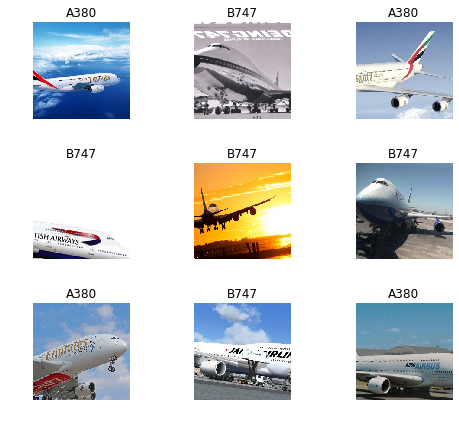

In [5]:
data = ImageDataBunch.from_folder(PATH, ds_tfms=get_transforms(), size=224)
data.normalize(imagenet_stats)
data.show_batch(rows=3, figsize=(7,6))
learn = ConvLearner(data, arch, metrics=error_rate) #accuracy

In [6]:
data.classes

['A380', 'B747']

How much input data do we have ?

(array([617.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 587.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

(array([154.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 154.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

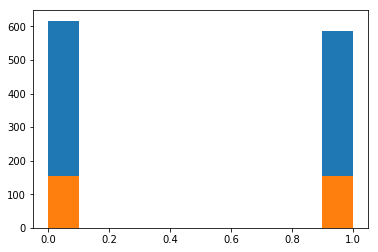

In [7]:
plt.hist(data.train_ds.ds.y)
plt.hist(data.valid_ds.ds.y)

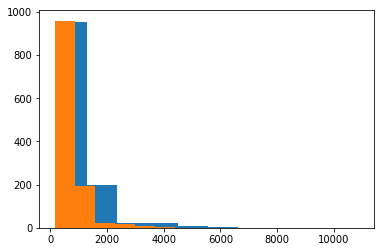

In [8]:
from PIL import Image
size_d = {k: Image.open(k).size for k in data.train_ds.ds.x}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)
plt.hist(row_sz);
plt.hist(col_sz);

Zoom on size below 1 000 pixels

(array([ 18.,  45.,  45.,  67., 112., 155.,  75.,  94.,  32.,  53.]),
 array([220. , 297.2, 374.4, 451.6, 528.8, 606. , 683.2, 760.4, 837.6,
        914.8, 992. ]),
 <a list of 10 Patch objects>)

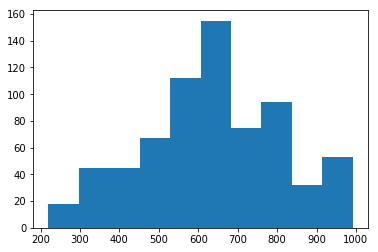

In [9]:
plt.hist(row_sz[row_sz < 1_000])

We have few data, but sizes are good.

### Guess learning rate

In [10]:
lrf=learn.lr_find(1e-6, end_lr=1)

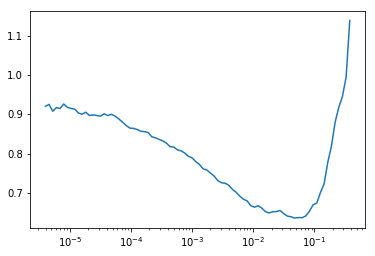

In [11]:
learn.recorder.plot()

Unfortunatly the learning rate finder do not work well with small dataset.

_23 october note :_ In the new version of fastai librairy it seems to work !

In [12]:
lr=1e-2
image_size=128
batch_size=64
epoch=30
data = ImageDataBunch.from_folder(PATH, ds_tfms=get_transforms(do_flip=False, flip_vert=False, max_rotate=0, max_zoom=0),
                                  size=224, num_workers=num_cpus()-2)
data.normalize(imagenet_stats)

In [13]:
learn = ConvLearner(data=data, arch=arch, ps=0.5, pretrained=False, metrics=accuracy)
learn.fit(epochs=epoch, lr=lr)

Total time: 11:02
epoch  train loss  valid loss  accuracy
1      0.903353    23.789579   0.529221  (00:26)
2      0.884077    1.076491    0.483766  (00:23)
3      0.838023    0.675168    0.564935  (00:22)
4      0.802059    0.763515    0.496753  (00:23)
5      0.784675    0.776739    0.512987  (00:22)
6      0.789788    0.706985    0.532468  (00:19)
7      0.797586    0.910506    0.496753  (00:21)
8      0.785976    0.768557    0.503247  (00:22)
9      0.781022    0.710518    0.548701  (00:21)
10     0.778320    0.696001    0.551948  (00:22)
11     0.778374    0.688221    0.519481  (00:22)
12     0.778114    0.693473    0.512987  (00:23)
13     0.773748    1.379197    0.561688  (00:22)
14     0.796923    0.736270    0.516234  (00:22)
15     0.795985    2.998698    0.506494  (00:20)
16     0.786966    0.725840    0.493506  (00:21)
17     0.781446    0.694053    0.509740  (00:22)
18     0.768360    0.699319    0.545455  (00:21)
19     0.773973    0.716234    0.457792  (00:21)
20     0.76

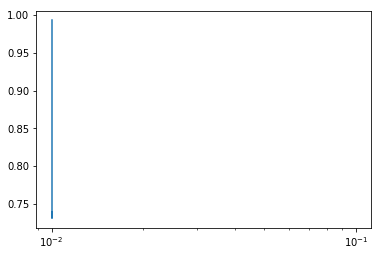

In [14]:
learn.recorder.plot()

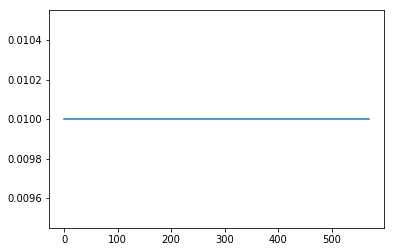

In [15]:
learn.recorder.plot_lr()

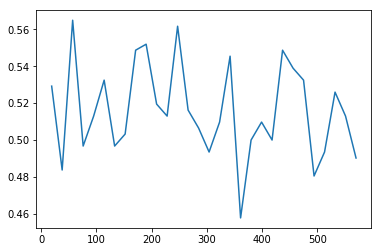

In [16]:
learn.recorder.plot_metrics()

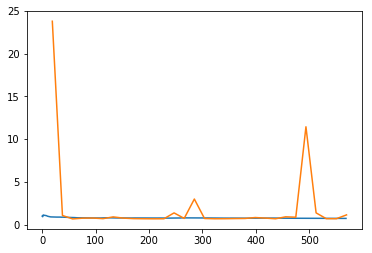

In [17]:
learn.recorder.plot_losses()

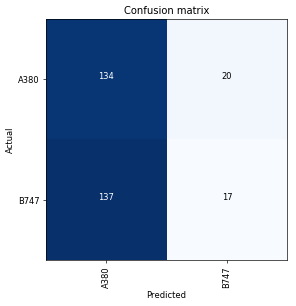

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

The model had learn quite nothing. But it is not surprising with so small dataset.

## Fine tuning

We will now use a pre-trained on ImageNet of resnet.

In [19]:
!rm -r {PATH}tmp

image_size=128
batch_size=64
learning_rate = 1e-2
lr=np.array([learning_rate/5,learning_rate/3,learning_rate])
epoch=30

data = ImageDataBunch.from_folder(PATH, ds_tfms=get_transforms(do_flip=False, flip_vert=False, max_rotate=0, max_zoom=0),
                                  size=224, num_workers=num_cpus()-2)
data.normalize(imagenet_stats)
learn = ConvLearner(data=data, arch=arch, ps=0.5, pretrained=True, metrics=accuracy)
learn.unfreeze()
learn.fit(epochs=epoch, lr=lr)

rm: cannot remove '../../datasets/boeing_vs_airbus/tmp': No such file or directory


Total time: 10:54
epoch  train loss  valid loss  accuracy
1      0.989776    88.787849   0.493507  (00:22)
2      0.870136    0.874546    0.519481  (00:21)
3      0.828496    0.832516    0.535714  (00:23)
4      0.789456    42.640923   0.500000  (00:22)
5      0.767290    1.872985    0.613636  (00:22)
6      0.740945    3.480949    0.610390  (00:22)
7      0.709084    0.683831    0.633117  (00:21)
8      0.678520    0.657079    0.613636  (00:21)
9      0.663821    0.663281    0.613636  (00:21)
10     0.652076    0.600742    0.668831  (00:20)
11     0.643434    0.611452    0.584416  (00:21)
12     0.643062    1.783132    0.538961  (00:21)
13     0.663185    0.691048    0.587662  (00:20)
14     0.641852    0.638249    0.678571  (00:23)
15     0.618349    0.628573    0.668831  (00:22)
16     0.589975    0.565651    0.688312  (00:21)
17     0.568649    0.687179    0.672078  (00:21)
18     0.557678    0.551594    0.688312  (00:21)
19     0.538891    0.637445    0.646104  (00:21)
20     0.52

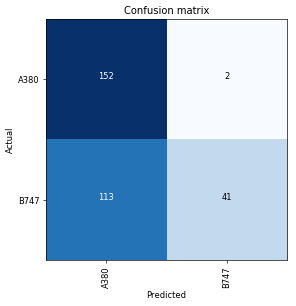

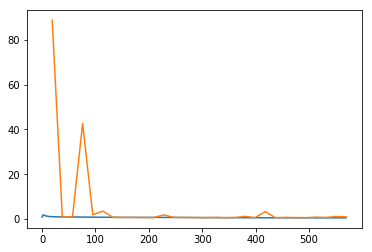

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)
learn.recorder.plot_losses()

Fine tunning realy improve the accuracy, it is the first thing to do with any project.

## Data augmentation
Apply random operations on pictures to help the model to generalize.
Data augmentation options : https://becominghuman.ai/data-augmentation-using-fastai-aefa88ca03f1

In [21]:
tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=10, max_zoom=1.1)

rm: cannot remove '../../datasets/boeing_vs_airbus/tmp': No such file or directory


Total time: 11:24
epoch  train loss  valid loss  accuracy
1      0.682614    1.427312    0.590909  (00:21)
2      0.449645    0.407689    0.853896  (00:22)
3      0.333344    0.394097    0.847403  (00:23)
4      0.267368    0.259139    0.892857  (00:22)
5      0.202207    0.250446    0.909091  (00:21)
6      0.156671    0.336952    0.892857  (00:21)
7      0.128412    0.389018    0.896104  (00:22)
8      0.116621    0.395853    0.886364  (00:23)
9      0.112529    0.695114    0.775974  (00:22)
10     0.109252    0.369108    0.883117  (00:22)
11     0.095097    0.312424    0.886364  (00:22)
12     0.091883    0.298953    0.915584  (00:22)
13     0.076735    0.429433    0.863636  (00:21)
14     0.076055    0.425804    0.870130  (00:23)
15     0.074605    0.364656    0.892857  (00:23)
16     0.066599    0.599427    0.844156  (00:23)
17     0.067326    0.375598    0.915584  (00:24)
18     0.068343    0.395706    0.883117  (00:23)
19     0.072710    0.349413    0.902597  (00:22)
20     0.07

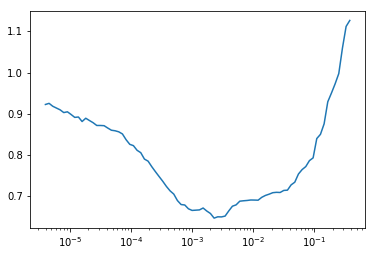

In [22]:
!rm -r {PATH}tmp
image_size=128
batch_size=64
learning_rate = 1e-3
lr = np.array([learning_rate/5,learning_rate/3,learning_rate])
epoch=30

data = ImageDataBunch.from_folder(PATH, ds_tfms=tfms, size=224, num_workers=num_cpus()-2)
data.normalize(imagenet_stats)
learn = ConvLearner(data=data, arch=arch, ps=0.5, pretrained=True, metrics=accuracy)
learn.unfreeze()
lrf=learn.lr_find(1e-6, end_lr=1)
learn.recorder.plot()
learn.fit(epochs=epoch, lr=lr)

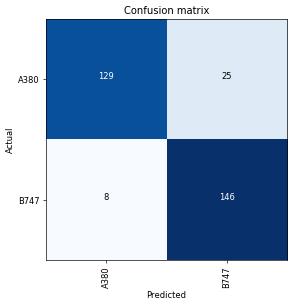

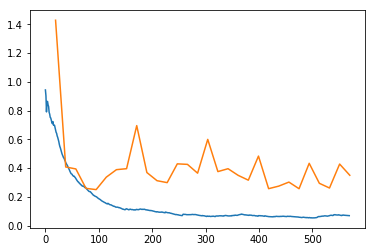

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)
learn.recorder.plot_losses()

Using data augmentation improve the accuracy by XX points.

## Multiple images sizes

Begining with smaller size of images sometimes improve the training accuracy.

rm: cannot remove '../../datasets/boeing_vs_airbus/tmp': No such file or directory


Total time: 02:24
epoch  train loss  valid loss  accuracy
1      0.947478    1.218693    0.600649  (00:14)
2      0.814973    0.763067    0.616883  (00:14)
3      0.688407    0.759212    0.665584  (00:13)
4      0.609259    0.649180    0.668831  (00:14)
5      0.535396    0.693773    0.698052  (00:13)
6      0.485915    0.931148    0.733766  (00:15)
7      0.433776    0.729196    0.727273  (00:15)
8      0.393011    0.863908    0.688312  (00:14)
9      0.366706    0.575943    0.766234  (00:15)
10     0.334948    0.735602    0.762987  (00:14)



Total time: 02:31
epoch  train loss  valid loss  accuracy
1      0.389704    0.812633    0.698052  (00:15)
2      0.353421    0.751535    0.720779  (00:16)
3      0.320661    0.779615    0.724026  (00:15)
4      0.300746    0.770343    0.694805  (00:14)
5      0.275437    1.302929    0.769481  (00:14)
6      0.259910    0.648832    0.762987  (00:14)
7      0.240144    0.632881    0.759740  (00:14)
8      0.202921    0.707281    0.779221  (00:16)
9      0.194784    0.631671    0.779221  (00:14)
10     0.175918    0.521603    0.805195  (00:15)



Total time: 02:24
epoch  train loss  valid loss  accuracy
1      0.217332    0.609885    0.769481  (00:14)
2      0.201588    0.567503    0.792208  (00:15)
3      0.183663    0.755184    0.750000  (00:14)
4      0.163838    0.715608    0.750000  (00:14)
5      0.154254    0.698467    0.772727  (00:14)
6      0.146008    0.823101    0.762987  (00:13)
7      0.140099    0.744240    0.746753  (00:14)
8      0.139959    0.749250    0.746753  (00:13)
9      0.130532    0.629462    0.782468  (00:14)
10     0.117736    0.790516    0.762987  (00:14)



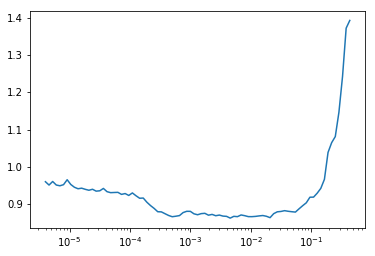

In [36]:
!rm -r {PATH}tmp
learning_rate = 1e-3
learning_rate = np.array([learning_rate/5,learning_rate/3,learning_rate])
dropout = 0.5 #[0.25,0.5]
tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=10, max_zoom=1.1)
data = ImageDataBunch.from_folder(PATH, ds_tfms=tfms, size=64) # ds_tfms=get_transforms()
data.normalize(imagenet_stats)
learn = ConvLearner(data=data, arch=arch, ps=0.5, pretrained=True, metrics=accuracy)
learn.unfreeze()
lrf=learn.lr_find(1e-6, end_lr=1)
learn.recorder.plot()

training_loop = [
    [256, 64, 10],
    [150, 128, 10],
    [123, 224, 10],
]
for bs, image_size, epoch in training_loop:
    data.size = image_size
    data.batch_size = bs
    learn.fit(epochs=epoch, lr=learning_rate)

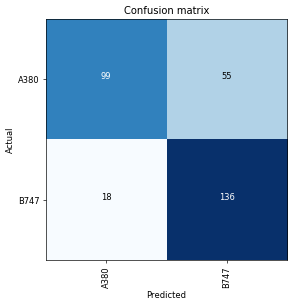

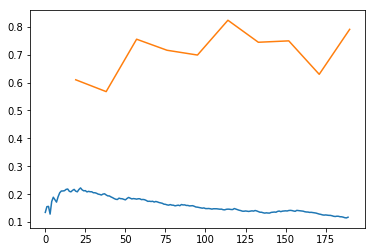

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)
learn.recorder.plot_losses()

Well, using multiple size did not realy help but it is something to try.

## 1Cycle Policy

We now use special training procedure wich made learning rate change while learning, see https://sgugger.github.io/the-1cycle-policy.html#the-1cycle-policy for more information.

rm: cannot remove '../../datasets/boeing_vs_airbus/tmp': No such file or directory


Total time: 03:24
epoch  train loss  valid loss  accuracy
1      0.779239    3.031912    0.525974  (00:20)
2      0.600150    0.954016    0.743506  (00:21)
3      0.497140    0.927935    0.733766  (00:20)
4      0.476240    1.561472    0.655844  (00:21)
5      0.449950    0.559331    0.769481  (00:20)
6      0.430581    0.960115    0.724026  (00:19)
7      0.397199    0.750417    0.788961  (00:20)
8      0.355121    0.320269    0.840909  (00:20)
9      0.303482    0.273377    0.896104  (00:20)
10     0.253877    0.263317    0.889610  (00:20)



Total time: 03:19
epoch  train loss  valid loss  accuracy
1      0.223932    2.846104    0.775974  (00:19)
2      0.304053    11.285070   0.496753  (00:19)
3      0.423748    9.692017    0.496753  (00:20)
4      0.474879    1.542210    0.662338  (00:20)
5      0.465356    0.844288    0.711039  (00:19)
6      0.455592    0.660034    0.711039  (00:21)
7      0.418310    0.678346    0.701299  (00:20)
8      0.360770    0.344114    0.844156  (00:19)
9      0.309258    0.369097    0.831169  (00:19)
10     0.271389    0.308742    0.870130  (00:19)



Total time: 03:25
epoch  train loss  valid loss  accuracy
1      0.193931    0.375276    0.814935  (00:25)
2      0.223991    0.726462    0.733766  (00:19)
3      0.279960    0.980863    0.629870  (00:20)
4      0.326227    34.960930   0.577922  (00:20)
5      0.387552    2.574461    0.581169  (00:19)
6      0.409041    0.423441    0.801948  (00:19)
7      0.385878    0.362922    0.837662  (00:20)
8      0.341301    0.507814    0.759740  (00:20)
9      0.303295    0.315644    0.847403  (00:21)
10     0.270021    0.326381    0.850649  (00:19)



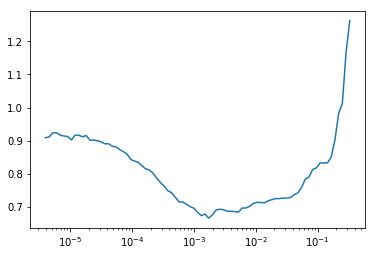

In [26]:
!rm -r {PATH}tmp


learning_rate = 1e-2
lr=np.array([learning_rate/5,learning_rate/3,learning_rate])
dropout = 0.5
#[0.25,0.5] 


data = ImageDataBunch.from_folder(PATH, ds_tfms=tfms, size=224) # ds_tfms=get_transforms()
data.normalize(imagenet_stats)
learn = ConvLearner(data=data, arch=arch, ps=0.5, pretrained=True, metrics=accuracy)
learn.unfreeze()
lrf=learn.lr_find(1e-6, end_lr=1)
learn.recorder.plot()

training_loop = [
    [256, 64, 10],
    [150, 128, 10],
    [123, 224, 10],
]
for bs, sz, epoch in training_loop:
    data.batch_size = bs
    data.size = sz
    learn.fit_one_cycle(cyc_len=epoch, max_lr=lr)

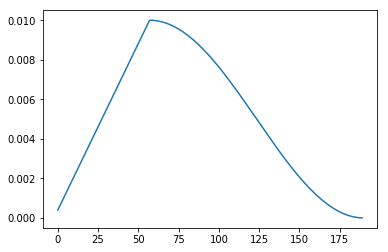

In [27]:
learn.recorder.plot_lr()

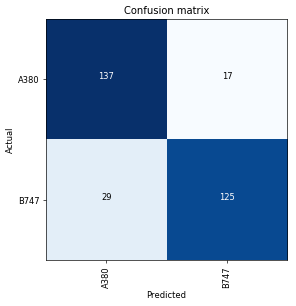

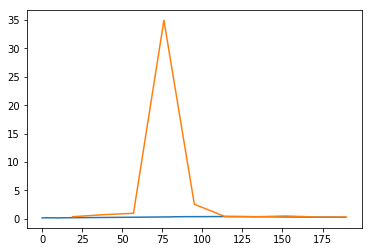

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)
learn.recorder.plot_losses()

OK, that give us another XXX points improvement !

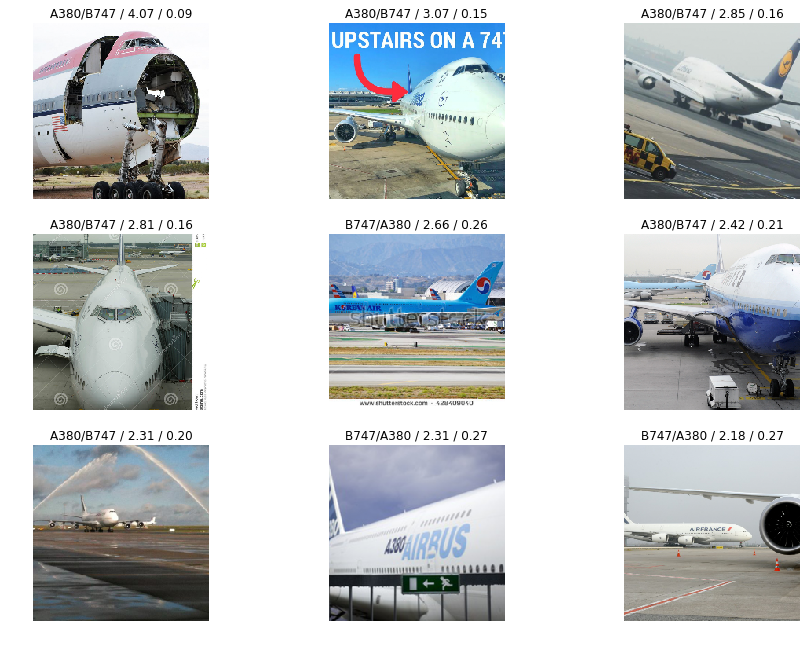

In [29]:
interp.plot_top_losses(9, figsize=(15,11))

In [30]:
learn.save('lesson01-final_model')

In [31]:
#loadmodel=False
loadmodel=False
if loadmodel==True:
    data = ImageDataBunch.from_folder(PATH, ds_tfms=get_transforms(), size=224)
    learn = ConvLearner(data=data, arch=arch, ps=0.5, pretrained=True, metrics=accuracy)
    #learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
    learn.load("lesson01-final_model")
    print("Model loaded")

# Prediction et visualisation

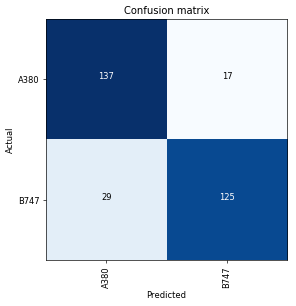

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

## Precision and Recall

It's good metrics to evaluate how the model perform : https://en.wikipedia.org/wiki/Precision_and_recall

We will compute them from the confusion matrix.

In [33]:
data.classes
cm = interp.confusion_matrix()
cm

['A380', 'B747']

array([[137,  17],
       [ 29, 125]])

In [34]:

# precission = VP / (VP + FP)
precision = cm[0][0]/(cm[0][1]+cm[0][0]);
print("Precision : ", precision)
# recall =  = VP / (VP + FN)
recall = cm[0][0]/(cm[1][0]+cm[0][0]);
print("recall : ", recall)
F1 = 2 * ((precision*recall)/(precision + recall))
print("F1 : ", F1)
F2 = 5 * ((precision*recall)/(4*precision + recall))
print("F2 : ", F2)

Precision :  0.8896103896103896
recall :  0.8253012048192772
F1 :  0.8562500000000002
F2 :  0.8374083129584353


Let's have a look at the 16 worst classified images.

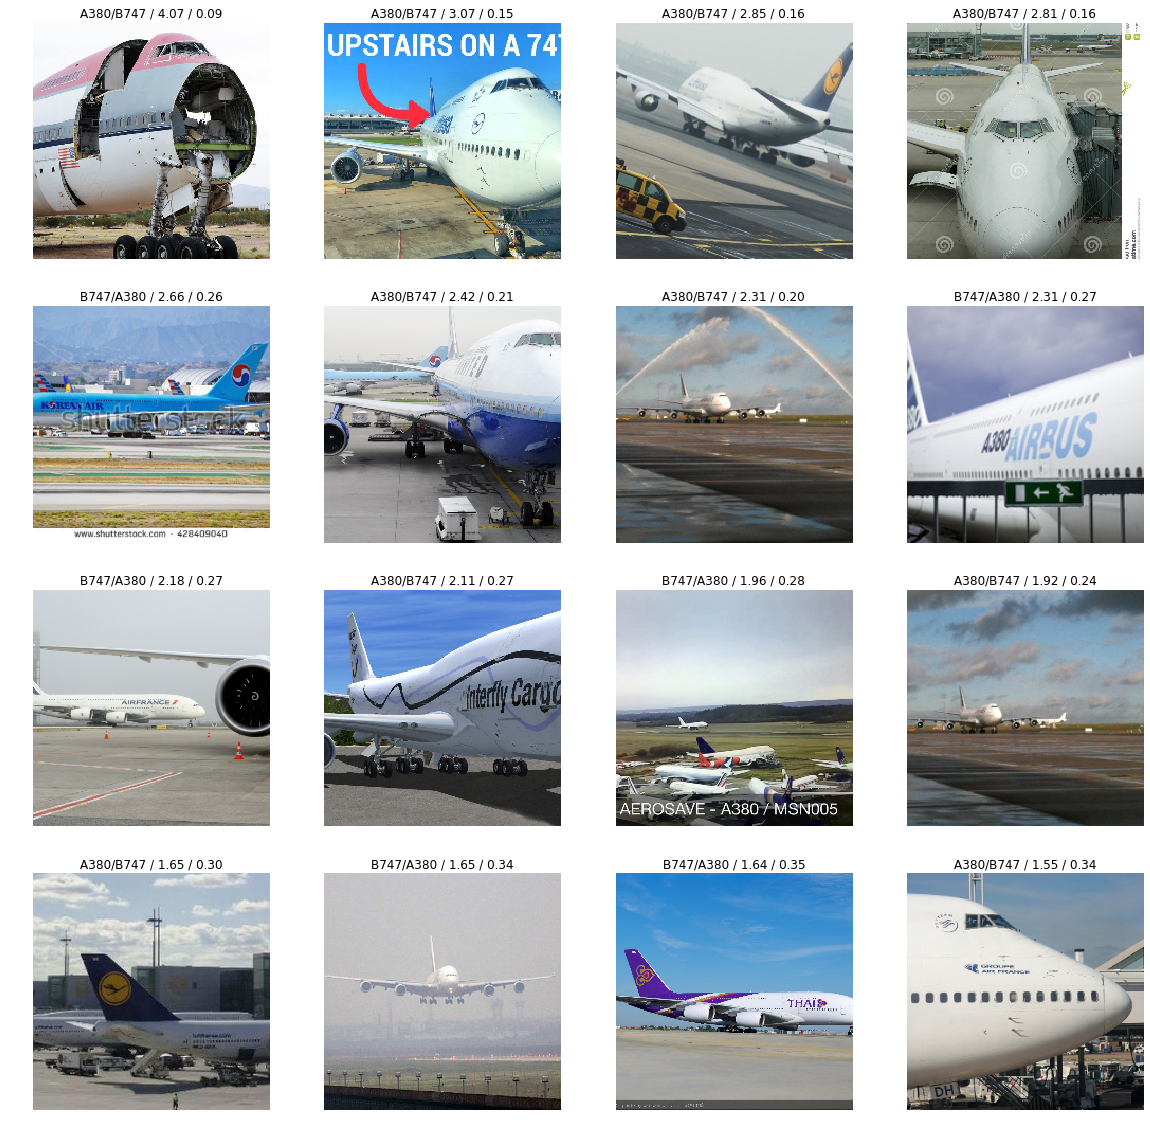

In [35]:
interp.plot_top_losses(16, figsize=(20,20))